In [18]:
%matplotlib inline
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 

from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets import make_blobs 

<hr>
<h1 id="clustering_vehicle_dataset">Clustering sur l'ensemble de données de véhicule</h1>

Imaginez qu'un constructeur automobile développe des prototypes pour un nouveau véhicule. Avant d'introduire le nouveau modèle dans sa gamme, le constructeur souhaite déterminer quels véhicules existants sur le marché ressemblent le plus aux prototypes, c'est-à-dire comment les véhicules peuvent être regroupés, quel groupe est le plus similaire au modèle, et donc quels modèles ils seront en concurrence.

Notre objectif ici est d'utiliser des méthodes de regroupement pour trouver les groupes de véhicules les plus distinctifs. Il résumera les véhicules existants et aidera les constructeurs à prendre des décisions concernant la fourniture de nouveaux modèles.


### Télécharger les données

Pour télécharger les données, nous utiliserons **`!wget`** pour les télécharger depuis IBM Object Storage.\
**Le saviez-vous ?** En matière d'apprentissage automatique, vous travaillerez probablement avec de grands ensembles de données. En tant qu'entreprise, où pouvez-vous héberger vos données ? IBM offre une opportunité unique aux entreprises, avec 10 To d'IBM Cloud Object Storage : [Inscrivez-vous maintenant gratuitement](http://cocl.us/ML0101EN-IBM-Offer-CC)


In [19]:
!wget -O cars_clus.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/cars_clus.csv

'wget' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


## Lire les données

Lisons l'ensemble de données pour voir quelles fonctionnalités le fabricant a collectées sur les modèles existants.


In [20]:
filename = 'cars_clus.csv'

#Read csv
pdf = pd.read_csv(filename)
print ("Forme du jeu de données : ", pdf.shape)

pdf.head(5)

Forme du jeu de données :  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


The feature sets include  price in thousands (price), engine size (engine_s), horsepower (horsepow), wheelbase (wheelbas), width (width), length (length), curb weight (curb_wgt), fuel capacity (fuel_cap) and fuel efficiency (mpg).


<h2 id="data_cleaning">Data Cleaning</h2>

Let's clean the dataset by dropping the rows that have null value:


In [21]:
print ("Forme du jeu de données avant nettoyage :", pdf.size)
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print ("Forme du jeu de données après nettoyage : ", pdf.size)
pdf.head(5)

Forme du jeu de données avant nettoyage : 2544
Forme du jeu de données après nettoyage :  1872


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


### Sélection de fonctionnalité

Sélectionnons notre ensemble de fonctionnalités :


In [22]:
featureset = pdf[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

### Normalisation

Nous pouvons maintenant normaliser l'ensemble de fonctionnalités. **MinMaxScaler** transforme les fonctionnalités en adaptant chaque fonctionnalité à une plage donnée. C'est par défaut (0, 1). Autrement dit, cet estimateur met à l'échelle et traduit chaque caractéristique individuellement de sorte qu'elle soit comprise entre zéro et un.


In [23]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #retourne un tableau numpy
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

Dans le clustering agglomératif, à chaque itération, l'algorithme doit mettre à jour la matrice de distance pour refléter la distance du cluster nouvellement formé avec les clusters restants dans la forêt.
Les méthodes suivantes sont prises en charge dans Scipy pour calculer la distance entre le cluster nouvellement formé et chacun :
\- Célibataire
\- Achevée
\- moyen
\- pondéré
\- centroïde

Nous utilisons **complet** pour notre cas, mais n'hésitez pas à le modifier pour voir comment les résultats changent.

Essentiellement, le clustering hiérarchique ne nécessite pas un nombre prédéfini de clusters. Cependant, dans certaines applications, nous voulons une partition de clusters disjoints comme dans le clustering plat.
Vous pouvez donc utiliser un fil de coupe :

Vous pouvez également déterminer directement le nombre de clusters :


Maintenant, tracez le dendrogramme :


<h2 id="clustering_using_skl">Clustering à l'aide de scikit-learn</h2>

Recommençons, mais cette fois en utilisant le package scikit-learn :


In [24]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         0.57777143 0.75455727 ... 0.28530295 0.24917241 0.18879995]
 [0.57777143 0.         0.22798938 ... 0.36087756 0.66346677 0.62201282]
 [0.75455727 0.22798938 0.         ... 0.51727787 0.81786095 0.77930119]
 ...
 [0.28530295 0.36087756 0.51727787 ... 0.         0.41797928 0.35720492]
 [0.24917241 0.66346677 0.81786095 ... 0.41797928 0.         0.15212198]
 [0.18879995 0.62201282 0.77930119 ... 0.35720492 0.15212198 0.        ]]


In [25]:
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')

C:\Users\Fousseyni\AppData\Local\Temp\ipykernel_2000\1633147189.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')


In [26]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )
    
dendro = hierarchy.dendrogram(Z_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

NameError: name 'pylab' is not defined

Maintenant, nous pouvons utiliser la fonction "AgglomerativeClustering" de la bibliothèque scikit-learn pour regrouper l'ensemble de données. L'AgglomerativeClustering effectue un clustering hiérarchique en utilisant une approche ascendante. Les critères de liaison déterminent la métrique utilisée pour la stratégie de fusion :

* Ward minimise la somme des différences au carré dans tous les groupes. Il s'agit d'une approche de minimisation de la variance et, en ce sens, elle est similaire à la fonction objectif k-means mais abordée avec une approche hiérarchique agglomérative.
* La liaison maximale ou complète minimise la distance maximale entre les observations de paires de grappes.
* Le couplage moyen minimise la moyenne des distances entre toutes les observations de paires de grappes.


In [27]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(dist_matrix)

agglom.labels_

C:\Users\Fousseyni\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([1, 2, 2, 3, 2, 4, 3, 2, 2, 2, 2, 2, 4, 4, 2, 1, 3, 2, 2, 2, 4, 1,
       5, 3, 3, 2, 3, 2, 1, 3, 3, 0, 0, 0, 0, 4, 2, 1, 3, 3, 2, 4, 2, 4,
       0, 3, 0, 1, 3, 3, 2, 4, 1, 1, 3, 2, 1, 3, 2, 2, 2, 4, 4, 4, 1, 3,
       3, 2, 3, 4, 3, 3, 3, 2, 4, 2, 2, 3, 2, 4, 4, 1, 3, 2, 2, 2, 3, 4,
       2, 4, 1, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 3, 2, 1, 1, 1,
       3, 0, 1, 1, 3, 1, 1], dtype=int64)

Nous pouvons ajouter un nouveau champ à notre dataframe pour afficher le cluster de chaque ligne :


In [28]:
pdf['cluster_'] = agglom.labels_
pdf.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,1
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,2
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,2
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,3
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Text(0, 0.5, 'mpg')

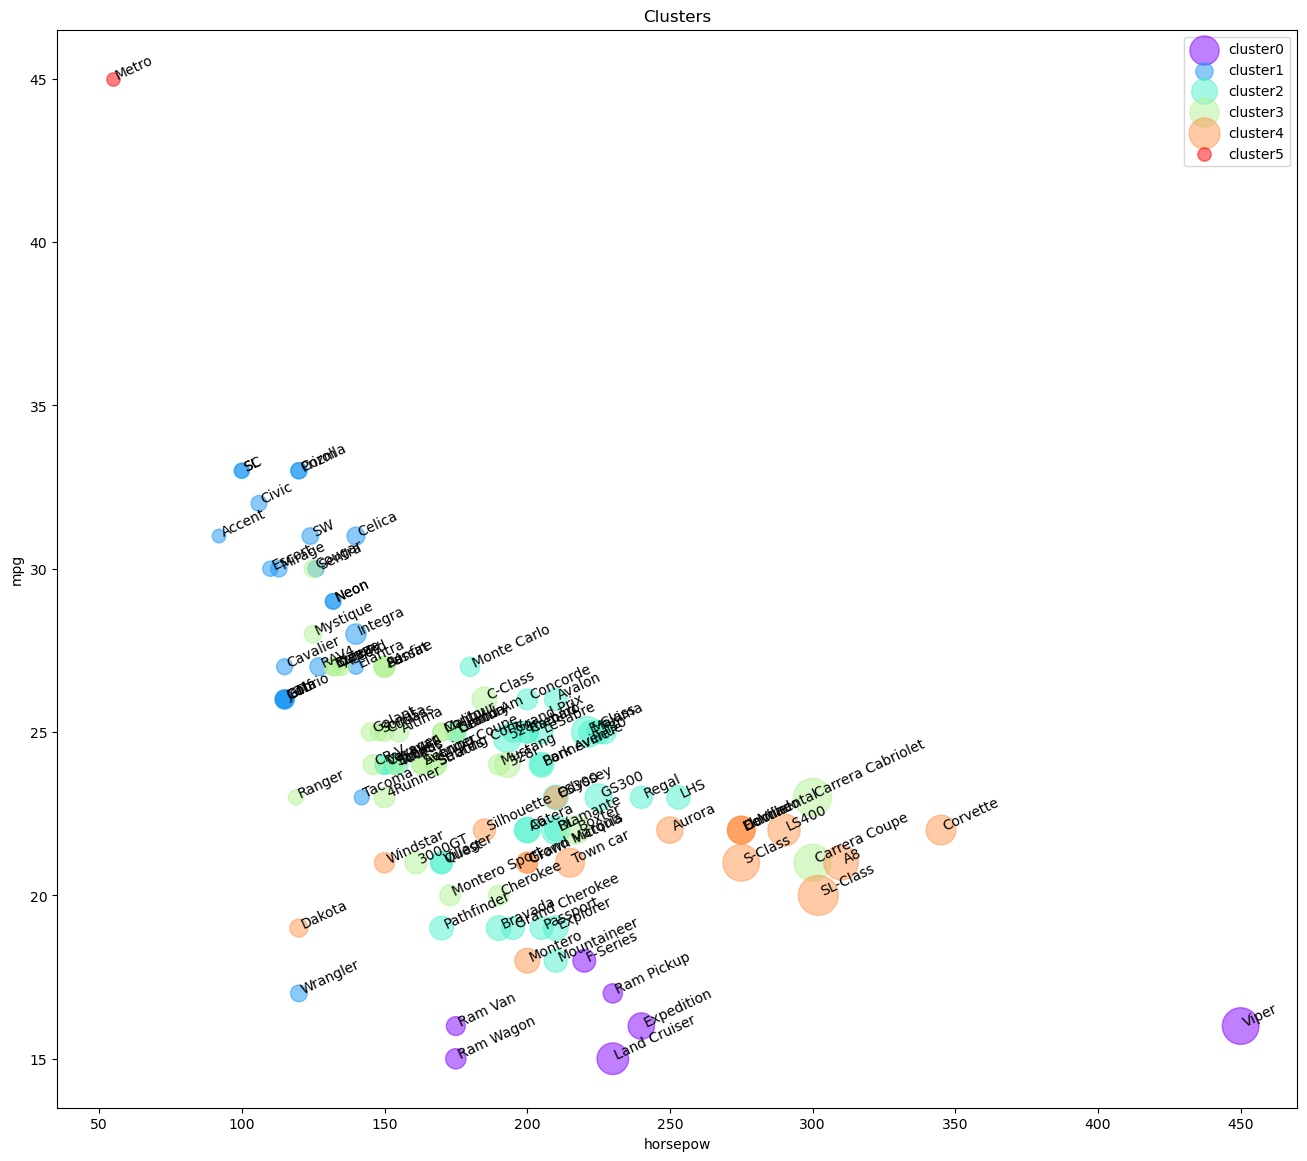

In [29]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

Comme vous pouvez le voir, nous voyons la distribution de chaque cluster à l'aide du nuage de points, mais il n'est pas très clair où se trouve le centroïde de chaque cluster. De plus, il existe 2 types de véhicules dans notre jeu de données, "camion" (valeur de 1 dans la colonne type) et "voiture" (valeur de 0 dans la colonne type). Nous les utilisons donc pour distinguer les classes et résumer le cluster. Nous comptons d'abord le nombre de cas dans chaque groupe :


In [30]:
pdf.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type
0         0.0      1
          1.0      6
1         0.0     20
          1.0      3
2         0.0     26
          1.0     10
3         0.0     28
          1.0      5
4         0.0     12
          1.0      5
5         0.0      1
Name: cluster_, dtype: int64

Now we can look at the characteristics of each cluster:


In [31]:
agg_cars = pdf.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

C:\Users\Fousseyni\AppData\Local\Temp\ipykernel_2000\3307995906.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  agg_cars = pdf.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()


horsepow  engine_s        mpg      price
cluster_ type                                            
0        0.0   450.000000  8.000000  16.000000  69.725000
         1.0   211.666667  4.483333  16.166667  29.024667
1        0.0   118.500000  1.890000  29.550000  14.226100
         1.0   129.666667  2.300000  22.333333  14.292000
2        0.0   203.615385  3.284615  24.223077  27.988692
         1.0   182.000000  3.420000  20.300000  26.120600
3        0.0   168.107143  2.557143  25.107143  24.693786
         1.0   155.600000  2.840000  22.000000  19.807000
4        0.0   267.666667  4.566667  21.416667  46.417417
         1.0   173.000000  3.180000  20.600000  24.308400
5        0.0    55.000000  1.000000  45.000000   9.235000

Il est évident que nous avons 3 clusters principaux avec la majorité des véhicules dans ceux-ci.

**Voitures**:

* Groupe 1 : avec un mpg presque élevé et une faible puissance.

* Groupe 2 : avec un bon mpg et une bonne puissance, mais un prix plus élevé que la moyenne.

* Groupe 3 : avec un faible mpg, une puissance élevée, le prix le plus élevé.

**Camions** :

* Groupe 1 : avec le mpg presque le plus élevé parmi les camions, et le plus bas en puissance et en prix.
* Groupe 2 : avec un mpg presque bas et une puissance moyenne, mais un prix plus élevé que la moyenne.
* Groupe 3 : avec un bon mpg et une bonne puissance, à bas prix.

Veuillez noter que nous n'avons pas utilisé le **type** et le **prix** des voitures dans le processus de clustering, mais le clustering hiérarchique pourrait forger les clusters et les discriminer avec une précision assez élevée.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Text(0, 0.5, 'mpg')

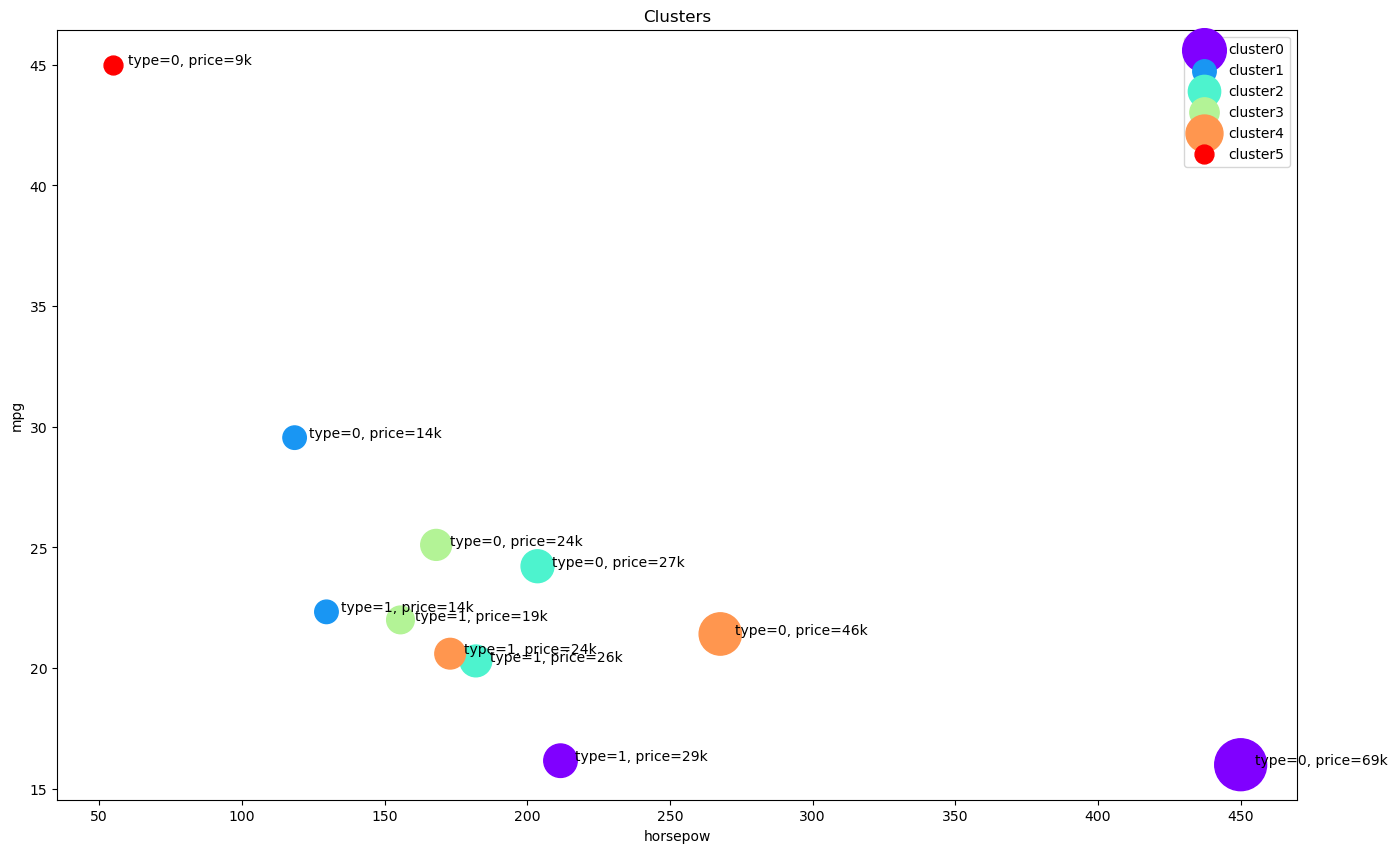

In [32]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')

plt.xlabel('horsepow')
plt.ylabel('mpg')


<h2>Vous voulez en savoir plus ?</h2>

IBM SPSS Modeler est une plate-forme d'analyse complète dotée de nombreux algorithmes d'apprentissage automatique. Il a été conçu pour apporter une intelligence prédictive aux décisions prises par des individus, des groupes, des systèmes - par votre entreprise dans son ensemble. Un essai gratuit est disponible via ce cours, disponible ici : <a href="https://www.ibm.com/analytics/spss-statistics-software?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel -SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Modélisateur SPSS</a>

En outre, vous pouvez utiliser Watson Studio pour exécuter ces blocs-notes plus rapidement avec des ensembles de données plus volumineux. Watson Studio est la principale solution cloud d'IBM pour les data scientists, conçue par des data scientists. Avec les notebooks Jupyter, RStudio, Apache Spark et les bibliothèques populaires pré-packagées dans le cloud, Watson Studio permet aux data scientists de collaborer sur leurs projets sans avoir à installer quoi que ce soit. Rejoignez dès aujourd'hui la communauté grandissante des utilisateurs de Watson Studio avec un compte gratuit sur <a href="https://www.ibm.com/cloud/watson-studio?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork -Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>


### Merci d'avoir terminé cet atelier !

## Auteur

Saïd Aghabozorgi

### Autres contributeurs

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENS18killsNetwork207 "_blank">Joseph Santarcangelo</a>

## Journal des modifications

| Date (AAAA-MM-JJ) | version | Modifié par | Modifier la description |
| ----------------- | ------- | ---------- | -------------------------------------------------- - |
| 2021-01-11 | 2.2 | Laksmi | Matrice de distance modifiée dans le clustering agglomératif |
| 2020-11-03 | 2.1 | Laksmi | URL mise à jour |
| 2020-08-27 | 2.0 | Lavania | Déplacement du laboratoire vers le référentiel de cours dans GitLab |

## <h3 align="center"> © IBM Corporation 2020. Tous droits réservés. <h3/>
